In [134]:
#importando bibliotecas
import os
import base64
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

#grafico
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
# Lendo os arquivos
#df_docente = pd.read_csv("DM_DOCENTE.CSV", sep="|")
#df_aluno = pd.read_csv("DM_ALUNO.CSV", sep="|")
#df_variaveis = pd.read_excel("Dicionário de Variáveis.xls", "DM_ALUNO")
#df_codigo = pd.read_excel("Código_do_País_de_Nascimento_ou_Naturalização.xlsx")
df_disciplinas = pd.read_csv("dados_disciplinas.txt", sep=",")

In [188]:
df_disciplinas[df_disciplinas['MEDIA_FINAL']==-1]

,MATR_ALUNO,ANO,PERIODO,SITUACAO,MEDIA_FINAL,NUM_FALTAS,DISCIPLINA,SITUACAO_NUM
9,8,2013,2,Equivalencia curricular,-1,-1,4,0
27,20,2013,1,Equivalencia curricular,-1,-1,4,0
72,38,2016,1,Equivalencia curricular,-1,-1,4,0
100,47,2013,2,Trancamento parcial,-1,-1,2,0
130,61,2013,1,Trancamento parcial,-1,-1,5,0
...,...,...,...,...,...,...,...,...
4593,819,2017,2,Dispensado,-1,-1,1,0
4594,819,2017,2,Dispensado,-1,-1,2,0
4595,819,2017,2,Dispensado,-1,-1,3,0
4596,819,2017,2,Dispensado,-1,-1,4,0


In [147]:
df_disciplinas['SITUACAO_NUM'] = (df_disciplinas['SITUACAO'] == 'Aprovado').astype(int)

In [103]:
df_disciplinas_sem_equivalencia = df_disciplinas[df_disciplinas['SITUACAO'] != 'Equivalencia curricular']

In [117]:
df_disciplinas_aprovado_ou_reprovado = df_disciplinas[(df_disciplinas['SITUACAO'] == 'Aprovado') | (df_disciplinas['SITUACAO'] == 'Reprovado')] 

In [ ]:
df_disciplinas_media_maior_zero = df_disciplinas[df_disciplinas['MEDIA_FINAL'] > 0]

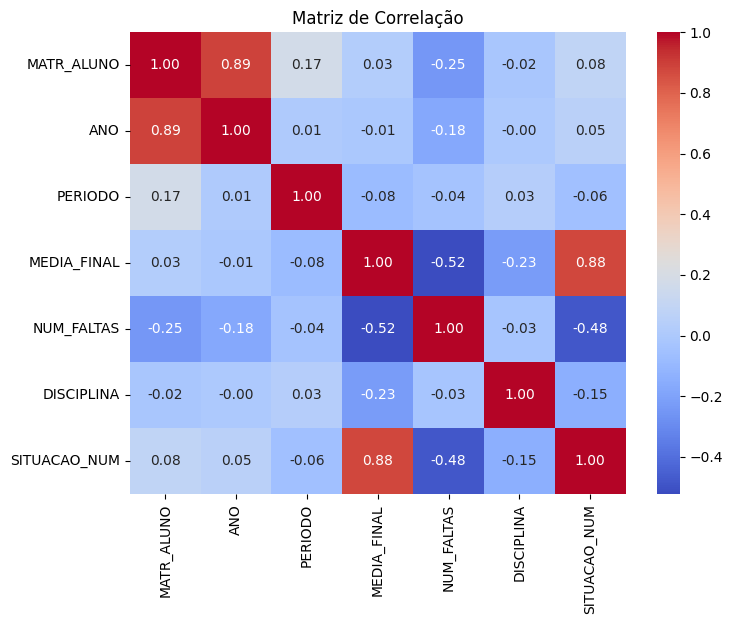

In [209]:
# plotar correlação alunos (Não funcionou, queria ver quais são as variáveis que podemos eliminar pela correlação)

corr = df_disciplinas_media_maior_zero.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [201]:
df_disciplinas_remove_media_negativa = df_disciplinas[ (df_disciplinas['MEDIA_FINAL'] != -1)] 

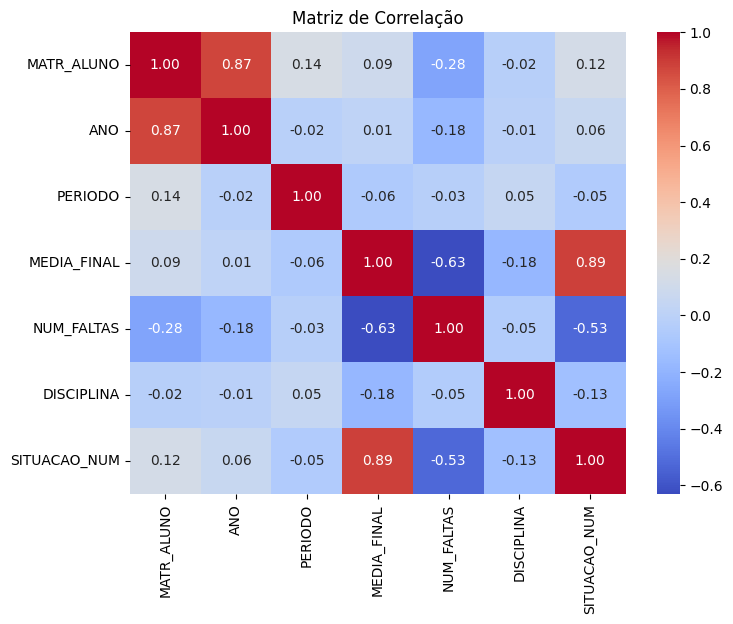

In [205]:
# plotar correlação alunos (Não funcionou, queria ver quais são as variáveis que podemos eliminar pela correlação)

corr = df_disciplinas_remove_media_negativa.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
X = df_disciplinas_media_maior_zero[['MATR_ALUNO', 'ANO', 'PERIODO', 'MEDIA_FINAL', 'NUM_FALTAS', 'DISCIPLINA', 'SITUACAO_NUM']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=2, min_samples=50)
clusters = dbscan.fit_predict(X_scaled)

df_disciplinas_media_maior_zero['cluster_dbscan'] = clusters

pd.crosstab(df_disciplinas_media_maior_zero['cluster_dbscan'], df_disciplinas_media_maior_zero['SITUACAO_NUM'])

In [227]:
X = df_disciplinas_remove_media_negativa[['MATR_ALUNO', 'ANO', 'PERIODO', 'MEDIA_FINAL', 'NUM_FALTAS', 'DISCIPLINA', 'SITUACAO_NUM']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=10)
clusters = dbscan.fit_predict(X_scaled)

df_disciplinas_remove_media_negativa['cluster_dbscan'] = clusters

pd.crosstab(df_disciplinas_remove_media_negativa['SITUACAO'], df_disciplinas_remove_media_negativa['cluster_dbscan'])

C:\Users\talle\AppData\Local\Temp\ipykernel_16244\3577417507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disciplinas_remove_media_negativa['cluster_dbscan'] = clusters


cluster_dbscan,-1,0,1,2,3
SITUACAO,,,,,
Aprovado,1,1118,0,958,0
Equivalencia curricular,0,0,2,0,0
Reprovado,0,0,487,0,630
Reprovado por Frequencia,5,0,500,0,416


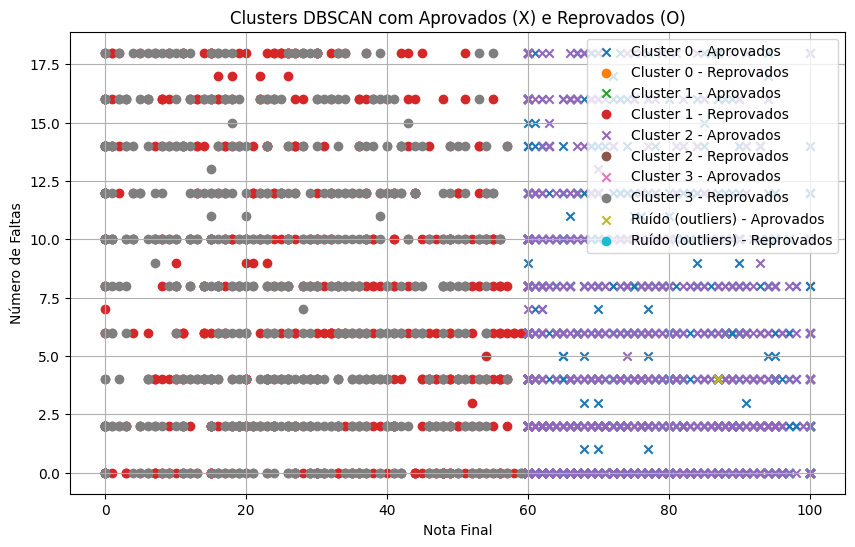

In [225]:
plt.figure(figsize=(10, 6))

clusters = df_disciplinas_remove_media_negativa['cluster_dbscan'].unique()

for cluster in clusters:
    # Mask do cluster
    mask_cluster = df_disciplinas_remove_media_negativa['cluster_dbscan'] == cluster

    # Separar aprovados e reprovados dentro do cluster
    mask_ap = mask_cluster & (df_disciplinas_remove_media_negativa['SITUACAO'] == 'Aprovado')
    mask_rep = mask_cluster & (df_disciplinas_remove_media_negativa['SITUACAO'] == 'Reprovado')

    # Nome do cluster para legenda
    if cluster == -1:
        cluster_label = "Ruído (outliers)"
    else:
        cluster_label = f"Cluster {cluster}"

    # Plotar Aprovados (X)
    plt.scatter(
        df_disciplinas_remove_media_negativa.loc[mask_ap, 'MEDIA_FINAL'],
        df_disciplinas_remove_media_negativa.loc[mask_ap, 'NUM_FALTAS'],
        label=f"{cluster_label} - Aprovados",
        marker='x'
    )

    # Plotar Reprovados (O)
    plt.scatter(
        df_disciplinas_remove_media_negativa.loc[mask_rep, 'MEDIA_FINAL'],
        df_disciplinas_remove_media_negativa.loc[mask_rep, 'NUM_FALTAS'],
        label=f"{cluster_label} - Reprovados",
        marker='o'
    )

plt.xlabel("Nota Final")
plt.ylabel("Número de Faltas")
plt.title("Clusters DBSCAN com Aprovados (X) e Reprovados (O)")
plt.legend()
plt.grid(True)
plt.show()